# 準備

## sys.pathの設定

In [2]:
import sys
sys.path.append('..')

# network modified

## layers

In [3]:
import numpy as np
from common import layers
from collections import OrderedDict
from common import functions
from data.mnist import load_mnist
import matplotlib.pyplot as plt


# ReLU layer
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        # mask.shape = x.shape
        # True or Falseを要素として持つ
        self.mask = (x <= 0)
        out = x.copy()
        # Trueの箇所を0にする
        out[self.mask] = 0

        return out

    def backward(self, dout):
        # Trueの箇所を0にする
        dout[self.mask] = 0
        dx = dout

        return dx
    
# Affine layer(全結合 layer)
class Affine:
    
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        out = np.dot(self.x, self.W) + self.b
        
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx


## two layer network class

In [4]:
class TwoLayerNet:
    '''
    input_size: 入力層のノード数
    hidden_size: 隠れ層のノード数
    output_size: 出力層のノード数
    weight_init_std: 重みの初期化方法
    '''
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = layers.Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = layers.SoftmaxWithLoss()
        
    # 順伝播
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # 誤差
    def loss(self, x, d):
        y = self.predict(x)
        return self.lastLayer.forward(y, d)
    
    # 精度
    def accuracy(self, x, d):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        accuracy = np.sum(y == d) / float(x.shape[0])
        return accuracy
             
    # 勾配
    def gradient(self, x, d):
        # forward

        self.loss(x, d)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W2'], grad['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad


## 1_4_1_mnist_sample modified

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.12
                : 10. 正答率(テスト) = 0.132
Generation: 20. 正答率(トレーニング) = 0.32
                : 20. 正答率(テスト) = 0.2829
Generation: 30. 正答率(トレーニング) = 0.39
                : 30. 正答率(テスト) = 0.3973
Generation: 40. 正答率(トレーニング) = 0.46
                : 40. 正答率(テスト) = 0.4372
Generation: 50. 正答率(トレーニング) = 0.53
                : 50. 正答率(テスト) = 0.5396
Generation: 60. 正答率(トレーニング) = 0.59
                : 60. 正答率(テスト) = 0.5018
Generation: 70. 正答率(トレーニング) = 0.59
                : 70. 正答率(テスト) = 0.5744
Generation: 80. 正答率(トレーニング) = 0.73
                : 80. 正答率(テスト) = 0.619
Generation: 90. 正答率(トレーニング) = 0.64
                : 90. 正答率(テスト) = 0.6608
Generation: 100. 正答率(トレーニング) = 0.77
                : 100. 正答率(テスト) = 0.7334
Generation: 110. 正答率(トレーニング) = 0.79
                : 110. 正答率(テスト) = 0.7436
Generation: 120. 正答率(トレーニング) = 0.8
                : 120. 正答率(テスト) = 0.7679
Generation: 130. 正答率(トレーニング) = 0.76
                : 130. 正答率(テスト) = 0.7866
Generation

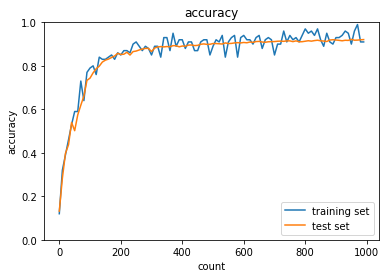

In [5]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = TwoLayerNet(input_size=784, hidden_size=40, output_size=10)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'b1', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()